# Model ML Project: Time for Tea

## Part 2 Design and Build

This project uses the time-for-tea use case to demo the process of building a complete ML project, excluding deployment.

The process is based on Chapter 2 of:

### **Hands on Machine Learning with Scikit-Learn, Keras and TensorFlow**

1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution. (not included here)
8. Launch, monitor, and maintain your system. (not included here)


This part describes the main stages of the project including the ML itself

## <font color='blue'>Headline Findings</font>

NB: The aim of this exercise was to demo the main staps in a ML project, there are many other things that could be done to optimise the approach and models and potentially improve results.

We pre-processed the data (kettle energy use, total energy use) to transform it from ~8 sec to 5 minutely. From this we extracted features for each 5 min period, including the max_diff, max-minus-min, max power, mean power, weekday/weekend, daytime/nighttime for each 5 min period. Of these the max_diff, mean, max-minus-min and max where most important.

The random forest model performed best, closely followed by SVM (but SVM was a lot slower). An ensemble of RF and SVM gave a small improvement. Final test results against the unseen test data were:

Precision: 0.906
Recall: 0.752

The model trained against one house was completely unable to predict kettle use at a new house, indicating overfitting are an issue with the approach. 

#### Side experiemnts
Just out of curiosity we did a couple of side experiments (details in separate notebooks):

1. Fitting model to data from several homes and then trying to predict a home that the model hadn't seen. The model failed to predict the new home.

2. Applying a very simply numpy-based approach that just looked for spikes of the right hight (no ML algo). This was a bit better than the ensemble model!! However it needed tuning quite precisely to the kettle size so would require this as input for each house. However, given the ML models weren't transferable so far to new homes, they may also require this as an input.

## <font color='blue'>Overall Project Aim</font>

The aim of this project is to explore whether it is possible to identify kettle use from a disaggregated data set using ML algorithms. The output would be used to alert carers to potentail issues with a vulnerable person.

The project uses the freely available REFIT data set: https://pureportal.strath.ac.uk/en/datasets/refit-electrical-load-measurements-cleaned

## <font color=blue>1. Look at the Big Picture</font>

### Frame the problem

 - We want to be able to identify instances of kettle usage from aggregated smart meter data of the type collected by a electricity CAD device (e.g. minutely total energy consumption).
 
Use Case
 
 - The use case is alerting if no kettle use is detected during a period where we would expect it (e.g. there is noboady active at home when we expect there to be, indicating a potential issue).
 
 - The output of the model will be a time series (e.g. Half-Hourly) with a Boolean value for kettle use detected. This would be ingested by an alerting algorithm that would match the Boolean with an expected value and alert if discrepancies are above a threshold.
 
 - A further iteration could include a probability that kettle was detected in addition to the Boolean.
 
Current Solution

 - Simply compare energy use over last e.g. Hour with use over last few weeks.
 - This has an advantage in that it also detects broader changes in energy use which could be important for wellbeing but it is very imprecise and hard to interpret. 
 - Also it can't detect absence or presence of specific actions from an individual which are simpler to interpret (e.g. no kettle use before midday -> very unsual, check on person; kettle use detected before midday -> person is up and active).
 
ML type

 - Supervised, batch-learning, classification problem
 - We will need labelled data of total energy consumption and whether period included kettle usage.
 - Later iterations could try to generalise to different kettle types or households with different appliance mixes which could include clustering but we're unlikely to have enough data for this in the short-term.

### Performance Measure

 - Confusion Matrix
 - Precision/Recall (this is preferred over ROC curve when we care more about false positives)
 - We want to pay particular attention to false positives - i.e. we don't want to report that a kettle was used when it wasn't or we might miss the rare cases where the person is in trouble.

### Assumptions

 - False negatives are more permissible than false positives, depending on performance we may need to consider false positives weighting
 - Time resolution will initially be 1 min (we'll need to do some preprocessing to get this)
 - Data will be further aggregated downstream to produce alerting based on e.g. number of kettle uses in last hour.
 - Initially we will use data from one home, later we will attempt to generalise the model using data from a range of homes.

## <font color=blue>2. Get the Data</font>

Note the data has been pre-processed already in the Part 1 notebook and now consists of approx 8 sec time-stamped data of total energy use and kettle energy use at one dwelling.

We do some more processing below before creating the test/train split as we need to preserve contiguous date times (i.e. adjacent records) and do some resampling first.

## <font color=blue>3. Discover and Visualise the Data to look for Insights</font>

 - This was done partly in the preprocessing in the part1 notebook, and partly below were we looked at fraction of kettles active and plotted the data, although we could have done this more formally and in more detail but the simplicity of the data didn't lend itself to this.

## <font color=blue>4. Prepare the Data for Machine Learning - Part A </font>

Part A is not ML-specific data processing but a way of presenting the data so as to expose potentially useful features from the very limited inputs we have (total energy and kettle energy). The ML specific processing is done in Part B.

#### Includes the following processing steps
 - Resample
 - Return min, max, mean and max abs diff between adjacent elements at 5 min resolution
 - Feature engineering, weekday/weekend, daytime/night-time, kettle-active/inactive...
 - Remove NaN and periods with data issues
 - Splitting the data into test and train data sets (don't look at the test set again until the end!)
 
Note the data has been pre-processed already in the Part 1 notebook and now consists of approx 8 sec time-stamped data of total energy use and kettle energy use at one dwelling

In [51]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [52]:
def read_data(filename):
    
    df = pd.read_csv(filename, index_col=[0], parse_dates=True)
    df.rename(columns={df.columns[0]: 'total', df.columns[1]: 'kettle'}, inplace=True)
    return df

In [53]:
def calc_agg_stats(data):
    return data.min(), data.max(), data.mean(), abs(data.diff()).max()

In [54]:
# Identify rows tagged as issue rows
# Assume resampled row is an issue row if > threshold of entries in period marked as issue

def calc_issue_bools(data, threshold=0.1):
    return ((sum(data > 0) / max(1, len(data))) > threshold) * 1

In [55]:
# Try two versions of kettle labeling

# if kettle is active for any period tag resampled row as kettle active
def calc_kettle_bools_any(data):
    return (data > 0).any()*1

# if kettle is active for more than threshold of entries tag resampled row as kettle active
def calc_kettle_bools_threshold(data, threshold=0.25):
    return ((sum(data > 0) / max(1, len(data))) > threshold) * 1

In [56]:
def resample_df(df_in, period='300s'):
    
    tot_energy_resampled = df_in[["total"]].resample('300s').apply(calc_agg_stats)
    df_energy = pd.DataFrame(tot_energy_resampled.total.tolist(), 
                                columns = ['min', 'max', 'mean', 'diff'],
                                index = tot_energy_resampled.index)
    
    kettle_resampled_any = df_in[["kettle"]].resample('300s').apply(
        calc_kettle_bools_any).rename(columns = {"kettle": "kettle_any"})
    
    kettle_resampled_threshold = df_in[["kettle"]].resample('300s').apply(
        calc_kettle_bools_threshold).rename(columns = {"kettle": "kettle_thresh"})
    
    issues_resampled = df_in[["Issues"]].resample('300s').apply(calc_issue_bools)
    
    df_out = pd.concat([df_energy, kettle_resampled_any, kettle_resampled_threshold, 
                    issues_resampled], axis=1)
    
    return df_out

In [57]:
def drop_nans_and_issue_rows(df):
    
    df.drop(df[df.Issues > 0].index, inplace=True)
    df.drop(["Issues"], axis=1, inplace=True)
    df.drop(df[df.isnull().any(axis=1)].index, inplace=True)
    
    return df


In [58]:
# This does everything
def preprocessing(filename):
    
    df_in = read_data(filename)
    df = resample_df(df_in, period='300s')
    df_out = drop_nans_and_issue_rows(df)
    
    return(df_out)   

In [59]:
df_processed = preprocessing(filename = "house8_processed.csv")
df_processed

,min,max,mean,diff,kettle_any,kettle_thresh
Time,,,,,,
2013-11-01 22:10:00,356.0,358.0,357.636364,2.0,0,0
2013-11-01 22:15:00,354.0,495.0,370.520000,136.0,0,0
2013-11-01 22:20:00,354.0,495.0,360.941176,139.0,0,0
2013-11-01 22:25:00,398.0,411.0,404.408163,6.0,0,0
2013-11-01 22:30:00,225.0,405.0,389.540000,173.0,0,0
...,...,...,...,...,...,...
2015-05-10 23:15:00,219.0,225.0,221.181818,2.0,0,0
2015-05-10 23:20:00,219.0,225.0,222.046512,4.0,0,0
2015-05-10 23:25:00,219.0,223.0,220.568182,3.0,0,0


In [60]:
#fraction of kettles
def get_labelled_fractions(df, field):
    fraction = (df[field] > 0).sum() / (df[field] == 0).sum()
    
    print(f"perc of {field} : {100*fraction:.2f}%")
    print(f"number of {field} : {(df[field]  > 0).sum()}")


In [61]:
get_labelled_fractions(df_processed, "kettle_any")
get_labelled_fractions(df_processed, "kettle_thresh")

perc of kettle_any : 3.04%
number of kettle_any : 4208
perc of kettle_thresh : 1.55%
number of kettle_thresh : 2169


## NOTE

At this point data has some useful features exposed but we still want to do some scaling, feature engineering and put the transformers into a proper pipeline

(0.0, 12000.0)

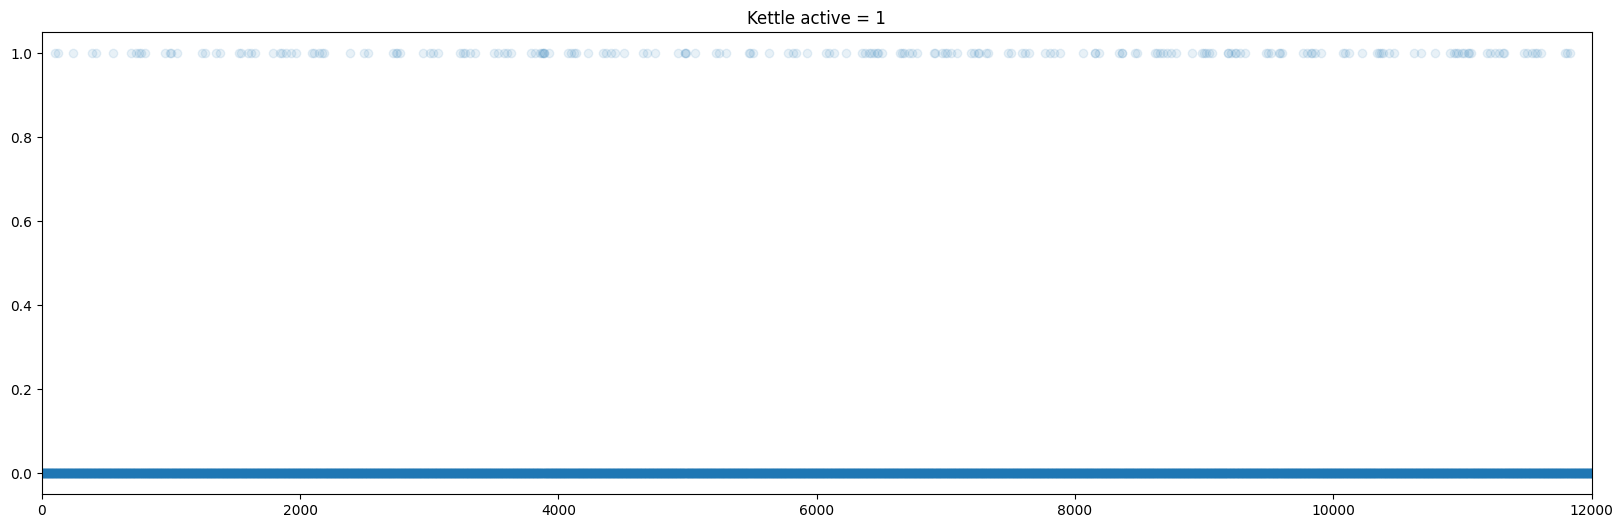

In [62]:
# Quick look at the data

plt.rcParams["figure.figsize"] = (20,6)

x = np.arange(len(df_processed.index))

plt.scatter(x, df_processed["kettle_thresh"]>0, alpha=.1, label="off")
plt.title("Kettle active = 1")

plt.show
plt.xlim(0,12000)

## Split into Train-Test sets
 - Save to .csv for convenience

In [63]:
from sklearn.model_selection import StratifiedShuffleSplit

In [64]:
# stratified split to get same dist of kettles active in train and test sets

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df_processed, df_processed["kettle_thresh"]):
    strat_train_set = df_processed.iloc[train_index]
    strat_test_set = df_processed.iloc[test_index]

In [65]:
# Check stratificaiton worked
get_labelled_fractions(df_processed, "kettle_thresh")
get_labelled_fractions(strat_train_set, "kettle_thresh")
get_labelled_fractions(strat_test_set, "kettle_thresh")

perc of kettle_thresh : 1.55%
number of kettle_thresh : 2169
perc of kettle_thresh : 1.55%
number of kettle_thresh : 1735
perc of kettle_thresh : 1.55%
number of kettle_thresh : 434


In [66]:
# Write the data to csv and work off these from now.
strat_train_set.to_csv("train_data.csv")
strat_test_set.to_csv("test_data.csv")

## <font color=blue>4. Prepare the Data for Machine Learning - Part B </font>

Here we deal with nity-gritty of feature engineering, transformers and pipelines to make pre-processing a single step process.

We save all the processing we've done up to now as .csv files and then read them in below. Next we apply ML specific data preparation and package this all neatly in pipelines.

### Nitty-Gritty of ML Starts Here

## Feature Engineering

In [9]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [10]:
filename = "train_data.csv"

train_set = pd.read_csv(filename, parse_dates=[0])

X = train_set.copy().drop(columns = ["kettle_any", "kettle_thresh"])
y = train_set["kettle_thresh"].reset_index(drop=True)

### Transformation Pipelines
 - Build pipeline to add features and apply standard scaling

In [2]:
class CatFeaturesAdder(BaseEstimator, TransformerMixin):
    """Custom class to work with scikit-learn pipelines etc"""
    
    def __init__(self, add_weekday=True, add_daytime=True): 
        self.add_weekday = add_weekday
        self.add_daytime = add_daytime
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        
        if self.add_weekday:
            day_of_week = X.Time.dt.dayofweek
            week_day = (day_of_week < 5) * 1
            X["week_day"] = week_day
            
        if self.add_daytime: # I may have deleted something from here by mistake
            hour_of_day = X.Time.dt.hour
            daytime = ((hour_of_day > 6) & (hour_of_day < 23)) * 1
            X["daytime"] = daytime
            
        return X.drop('Time', axis=1)


In [3]:
class NumFeaturesAdder(BaseEstimator, TransformerMixin):
    """Custom class to work with scikit-learn pipelines etc"""
    
    def __init__(self, add_max_min=True): 
        self.add_max_min = add_max_min
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
            
        if self.add_max_min:
            max_min = pd.DataFrame(abs(X["max"] - X["min"]))
            X["max_min"] = max_min
            
        return X
            

In [4]:
class Scaler(BaseEstimator, TransformerMixin):
    """Wrapper around the StandardScalar class to allow us to specify cols
    in the pipeline"""
    
    def __init__(self, scale_atribs=['min', 'max', 'mean', 'diff', 'max_min']): 
        self.sc = StandardScaler()
        self.scale_atribs = scale_atribs
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        
        X[self.scale_atribs] = self.sc.fit_transform(X[self.scale_atribs])
        return X

In [5]:
# create transofrmation pipeline
# standard scaler works better than max-min scaler as it tends to bunch data around zero

trans_pipeline = Pipeline([('cat_feat_adder', CatFeaturesAdder(add_weekday=True,
                                                               add_daytime=True)),
                           ('num_feat_adder', NumFeaturesAdder(add_max_min=True)),
                           ('scaler', Scaler(scale_atribs = ['min', 'max', 'mean', 
                                                             'diff', 'max_min']))])

In [11]:
# pass a copy of the data to not overwrite original
X1 = pd.DataFrame(data = trans_pipeline.fit_transform(X.copy()))

In [8]:
X1.head()

,min,max,mean,diff,week_day,daytime,max_min
0,-0.329083,-0.406738,-0.393987,-0.287111,1,1,-0.295639
1,0.130359,-0.177255,-0.047596,-0.283511,1,0,-0.292263
2,-0.336152,-0.412318,-0.399654,-0.288911,1,0,-0.298170
3,0.210938,-0.133311,0.014932,-0.282611,1,1,-0.287200
4,-0.187716,-0.336986,-0.288160,-0.286211,1,0,-0.295639


## <font color=blue>5. Select and Train a Model</font>

As it's a small data set we can throw a number of different models at it and just see how they perform. We use cross-validation to train and test models and get performance metrics

In [6]:
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

In [61]:
cols = ['min', 'max', 'mean', 'diff', 'max_min', 'week_day', 'daytime']

### Decision Tree

In [15]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X1[cols], y)

dt_precision = cross_val_score(dt_clf, X1[cols], y, cv=5, scoring='precision')
dt_recall = cross_val_score(dt_clf, X1[cols], y, cv=5, scoring='recall')

In [16]:
print(f"DT Precision: {dt_precision.mean():.3f}")
print(f"DT Recall: {dt_recall.mean():.3f}")

DT Precision: 0.807
DT Recall: 0.803


### Support Vector Machine

In [17]:
svm_clf = SVC()
svm_clf.fit(X1[cols], y)

svm_precision = cross_val_score(svm_clf, X1[cols], y, cv=5, scoring='precision')
svm_recall = cross_val_score(svm_clf, X1[cols], y, cv=5, scoring='recall')

In [18]:
print(f"SVM Precision: {svm_precision.mean():.3f}")
print(f"SVM Recall: {svm_recall.mean():.3f}")

SVM Precision: 0.844
SVM Recall: 0.862


In [20]:
# SVM slightly better but very slow, at least the SVC implementation, faster options available

### Random Forest

In [93]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X1[cols], y)

rf_precision = cross_val_score(rf_clf, X1[cols], y, cv=5, scoring='precision')
rf_recall = cross_val_score(rf_clf, X1[cols], y, cv=5, scoring='recall')

In [94]:
print(f"rf Precision: {rf_precision.mean():.3f}")
print(f"rf Recall: {rf_recall.mean():.3f}")

rf Precision: 0.846
rf Recall: 0.876


### Logistic Regression

In [23]:
lr_clf = LogisticRegression()
lr_clf.fit(X1[cols], y)

lr_precision = cross_val_score(lr_clf, X1[cols], y, cv=5, scoring='precision')
lr_recall = cross_val_score(lr_clf, X1[cols], y, cv=5, scoring='recall')


In [24]:
print(f"lr Precision: {lr_precision.mean():.3f}")
print(f"lr Recall: {lr_recall.mean():.3f}")

lr Precision: 0.056
lr Recall: 0.012


In [25]:
# wow, not sure why that is so bad!

### Stochastic Grad Descent Classifier

In [28]:
# sgd_clf = SGDClassifier()
# sgd_clf.fit(X1[cols], y)

# sgd_precision = cross_val_score(sgd_clf, X1[cols], y, cv=5, scoring='precision')
# sgd_recall = cross_val_score(sgd_clf, X1[cols], y, cv=5, scoring='recall')

In [27]:
print(f"sgd Precision: {sgd_precision.mean():.3f}")
print(f"sgd Recall: {sgd_recall.mean():.3f}")

sgd Precision: 0.000
sgd Recall: 0.000


## Random Forest - looks most promising

## Confusion Matrix

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

In [45]:
def confusion_matrix_from_classifier(X, y, classifier, threshold=None, method=None):
    """Call a cross_val predict method to get predictions then compare with labels
    Increase threshold for methods returning prob to reduce false positives"""
    
    if method:  
        y_train_pred_prob = cross_val_predict(classifier, X, y, cv=3, method=method)
    else:
        y_train_pred_prob = cross_val_predict(rf_clf, X1, y0, cv=3)
    
    if threshold: 
        y_train_pred = (y_train_pred_prob [:,1] >= threshold).astype('int')
    else:
        y_train_pred = y_train_pred_prob
        
    confusion = confusion_matrix(y, y_train_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion)

    disp.plot()
    plt.show()


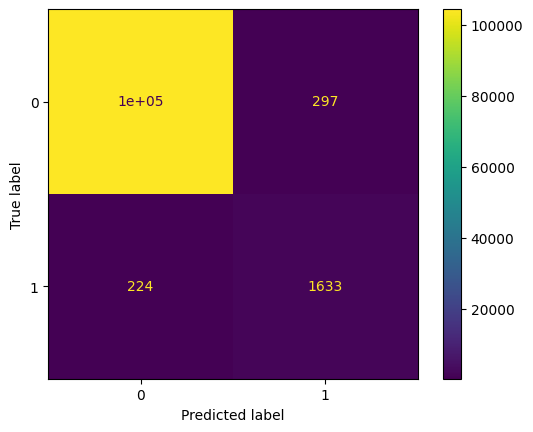

In [95]:
confusion_matrix_from_classifier(X1, y, classifier=rf_clf, 
                                  threshold=0.5, method='predict_proba')

## <font color=blue>6. Fine Tune Your Model</font>

Optimise hyperparams, here we just use a small grid search with limited success, there's lots more we could do though.

We also build an Ensemble model of two best approaches, SCM and Random Forest, again limited success but it demonstrates the concept.

## Grid search some Random Forest hyper params
 - score using precision - i.e. we don't want to label any non-active kettles as active

In [80]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [5, 10, 50], 'max_features': [2, 4, 7]}]

rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='precision', 
                           return_train_score=True, refit=True)

grid_search.fit(X1, y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [2, 4, 7],
                          'n_estimators': [5, 10, 50]}],
             return_train_score=True, scoring='precision')

In [81]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 10}

### Refine

In [82]:
param_grid = [
    {'n_estimators': [8, 10, 12], 'max_features': [1, 2, 3]},
    ]

rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='precision', return_train_score=True)
grid_search.fit(X1, y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [1, 2, 3],
                          'n_estimators': [8, 10, 12]}],
             return_train_score=True, scoring='precision')

In [83]:
grid_search.best_params_

{'max_features': 3, 'n_estimators': 8}

### See relative feature importance

 - we can prob drop min, week_day and daytime

In [84]:
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, list(X1)), reverse=True)

[(0.32527018470053304, 'diff'),
 (0.25730990100702117, 'mean'),
 (0.18116462834224636, 'max_min'),
 (0.1730401436925314, 'max'),
 (0.055569035311146556, 'min'),
 (0.005612828720996257, 'week_day'),
 (0.002033278225525335, 'daytime')]

## Use best params so far and drop weakest features

In [99]:
#cols = ['diff', 'mean', 'max_min', 'max']
cols = list(X1)

rf_clf = RandomForestClassifier(random_state=42, max_features=3, n_estimators=8)

rf_precision = cross_val_score(rf_clf, X1[cols], y, cv=5, scoring='precision')
rf_recall = cross_val_score(rf_clf, X1[cols], y, cv=5, scoring='recall')

In [100]:
print(f"rf Precision: {rf_precision.mean():.3f}")
print(f"rf Recall: {rf_recall.mean():.3f}")

rf Precision: 0.857
rf Recall: 0.831


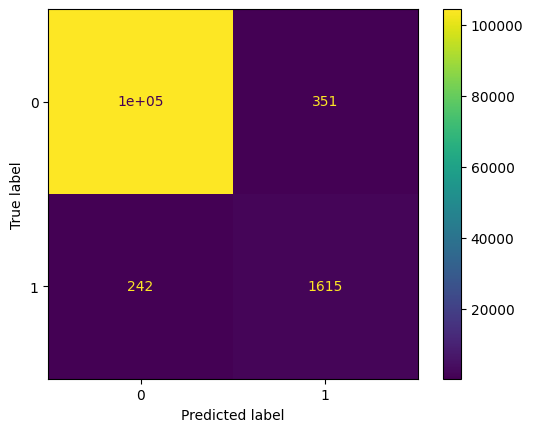

In [101]:
# Weirdly this is slightly worse than default params!?

confusion_matrix_from_classifier(X1, y, classifier=rf_clf, 
                                  threshold=0.5, method='predict_proba')

## Ensemble: Combine SVM and Random Forest

 - Only classify kettle as active if both models agree it's active


In [110]:
# Instantiate classifier and get prediciton probs
rf_clf = RandomForestClassifier(random_state=42, max_features=3, n_estimators=8)
y_train_pred_prob_RF = cross_val_predict(rf_clf, X1, y, cv=3, method='predict_proba')

# Convert to binary
threshold = 0.5
y_train_pred_RF = (y_train_pred_prob_RF [:,1] >= threshold).astype('int')

In [111]:
svm_clf = SVC()
y_train_pred_SVM = cross_val_predict(svm_clf, X1, y, cv=3)
#these are 1 or zero

In [138]:
y_pred_ens = ((y_train_pred_RF == 1) & (y_train_pred_SVM == 1)).astype('int')

In [139]:
y_train_pred_RF.sum()

1966

In [140]:
y_train_pred_SVM.sum()

1895

In [141]:
y_pred_ens.sum()

1743

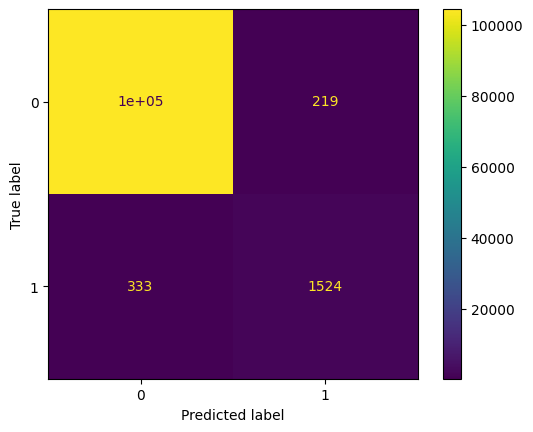

In [142]:
confusion = confusion_matrix(y, y_pred_ens)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)

disp.plot()
plt.show()

#### Ensemble reduces false positives quite a lot (by 132 good news) at expense of increasing false negatives (101).

In [86]:
def get_true_false_metrics(pred, actual):
    
    TP = len(pred[(pred == 1) & (actual == 1)])
    TN = len(pred[(pred == 0) & (actual == 0)])
    FP = len(pred[(pred == 1) & (actual == 0)])
    FN = len(pred[(pred == 0) & (actual == 1)])

    print(TP, TN, FP, FN)
    
    return TP, TN, FP, FN

In [1]:
TP, TN, FP, FN = get_true_false_metrics(pred=y_pred_ens, actual=y)

In [148]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f"rf Precision: {precision:.3f}")
print(f"rf Recall: {recall:.3f}")

rf Precision: 0.874
rf Recall: 0.821


# Final test against test data set

- This is the last step before deployment. If we make any optimisations based on this test then we have no clean way to test the model as this test performance will have influenced our decisions!

In [12]:
filename = "test_data.csv"

test_set = pd.read_csv(filename, parse_dates=[0])

X_test = test_set.copy().drop(columns = ["kettle_any", "kettle_thresh"])
y_test = test_set["kettle_thresh"].reset_index(drop=True)

In [13]:
# pass a copy of the data to not overwrite original
X_test1 = pd.DataFrame(data = trans_pipeline.fit_transform(X_test.copy()))

### Fit random forest

In [14]:
# Fit to training data
rf_clf = RandomForestClassifier(random_state=42, max_features=3, n_estimators=8)
rf_clf.fit(X1, y)

RandomForestClassifier(max_features=3, n_estimators=8, random_state=42)

In [21]:
y_test_pred_RF = rf_clf.predict(X_test1)

### Fit SVM

In [22]:
svm_clf = SVC()
svm_clf.fit(X1, y)

SVC()

In [23]:
y_test_pred_SVM = svm_clf.predict(X_test1)

### Ensemble

In [37]:
# Where both models agree
y_test_pred_ens = ((y_test_pred_RF == 1) & (y_test_pred_SVM == 1)).astype('int')

In [38]:
print(f'RF sum: {y_test_pred_RF.sum()}')
print(f'SVM sum: {y_test_pred_SVM.sum()}')
print(f'ENS sum: {y_test_pred_ens.sum()}')

RF sum: 430
SVM sum: 448
ENS sum: 385


### Ensemble model results

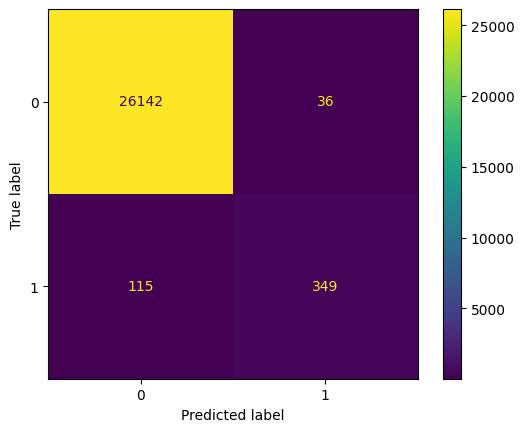

In [39]:
confusion = confusion_matrix(y_test, y_test_pred_ens)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)

disp.plot()
plt.show()

In [87]:
TP, TN, FP, FN = get_true_false_metrics(pred=y_test_pred_ens, actual=y_test)

precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

349 26142 36 115
Precision: 0.906
Recall: 0.752


Precision is great but we're missing a lot on recall

### RF Results only

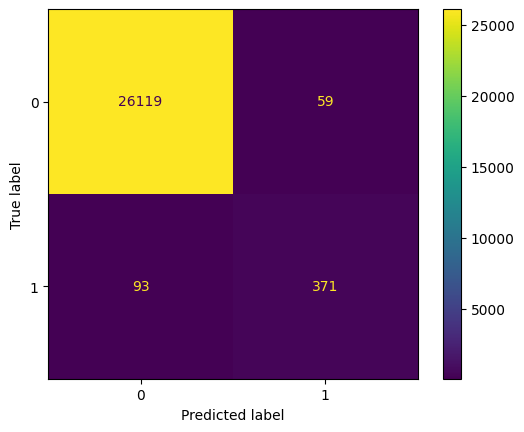

In [43]:
confusion = confusion_matrix(y_test, y_test_pred_RF)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)

disp.plot()
plt.show()

In [88]:
TP, TN, FP, FN = get_true_false_metrics(pred=y_test_pred_RF, actual=y_test)

precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

371 26119 59 93
Precision: 0.863
Recall: 0.800


Improved recall at expense of precision

### SVM Only Results

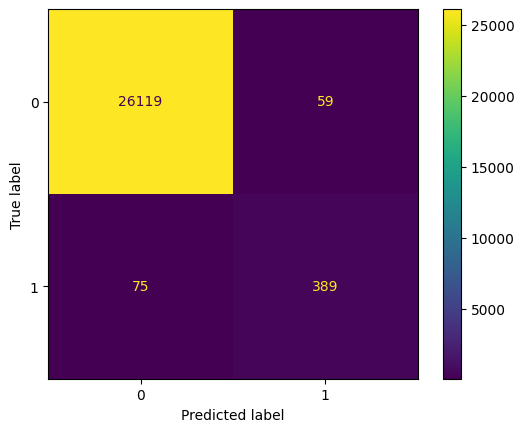

In [48]:
confusion = confusion_matrix(y_test, y_test_pred_SVM)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)

disp.plot()
plt.show()

In [89]:
TP, TN, FP, FN = get_true_false_metrics(pred=y_test_pred_SVM, actual=y_test)

precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

389 26119 59 75
Precision: 0.868
Recall: 0.838


Worse precision than ensemble but overall better than RF alone, we improved recall without affecting precision

NB: We shouldn't be doing this type of analysis on the test set btw!!

## What about a completely different home (just for fun)

i.e. if we train the model on House2 can we use it to predict House8 - spoiler alert, NO!

In [68]:
filename = "all_data_house8.csv"

test_set_house8 = pd.read_csv(filename, parse_dates=[0])

X_test_house8 = test_set_house8.copy().drop(columns = ["kettle_any", "kettle_thresh"])
y_test_house8 = test_set_house8["kettle_thresh"].reset_index(drop=True)

In [69]:
# pass a copy of the data to not overwrite original
X_test_house8_1 = pd.DataFrame(data = trans_pipeline.fit_transform(X_test_house8.copy()))

In [75]:
y_test_pred_RF_house8 = rf_clf.predict(X_test_house8_1)

In [76]:
y_test_pred_SVM_house8 = svm_clf.predict(X_test_house8_1)

In [77]:
# Where both models agree
y_test_pred_ens_house8 = ((y_test_pred_RF == 1) & (y_test_pred_SVM == 1)).astype('int')

In [78]:
print(f'RF sum: {y_test_pred_RF_house8.sum()}')
print(f'SVM sum: {y_test_pred_SVM_house8.sum()}')
print(f'ENS sum: {y_test_pred_ens_house8.sum()}')

RF sum: 486
SVM sum: 1296
ENS sum: 385


Interesting - big differences!

### RF results

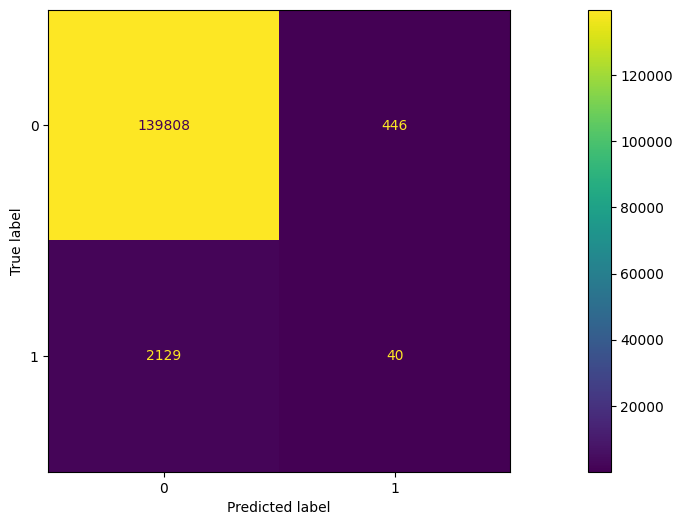

In [80]:
confusion = confusion_matrix(y_test_house8, y_test_pred_RF_house8)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)

disp.plot()
plt.show()

In [90]:
TP, TN, FP, FN = get_true_false_metrics(pred=y_test_pred_RF_house8, actual=y_test_house8)

precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

40 139808 446 2129
Precision: 0.082
Recall: 0.018


### SVM Results

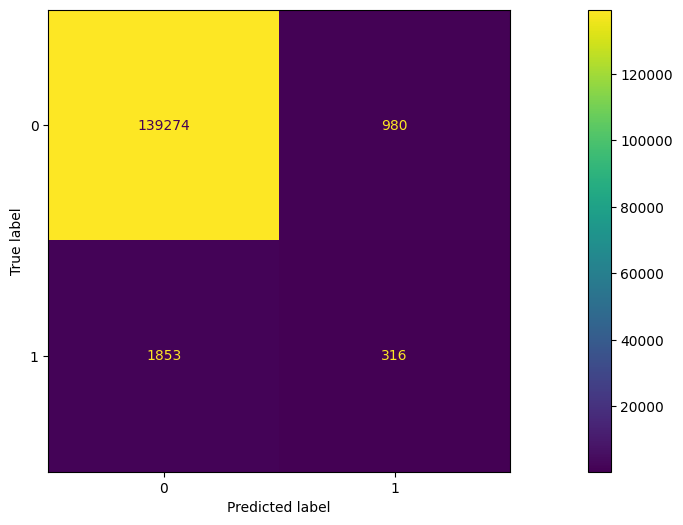

In [92]:
confusion = confusion_matrix(y_test_house8, y_test_pred_SVM_house8)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)

disp.plot()
plt.show()

In [93]:
TP, TN, FP, FN = get_true_false_metrics(pred=y_test_pred_SVM_house8, actual=y_test_house8)

precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

316 139274 980 1853
Precision: 0.244
Recall: 0.146


### We seem to have a very big overfitting issue - i.e. the model is only applicable to the home it was trained on.

Lots we could look at:
 - check for mistakes/set up better pipeline
 - remove abs consumption values (e.g. max, min and replace with relative values or even remove them and just work with diffs)...

# THE END
## Now go and deploy it :-) 